YOU NEED TO CHANGE THE REFINEMENT PATCH TO ACCOMMODATE THE ORDER OF INTERPOLATION FOR COARSER GRIDS!!!

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh_min = 16
refRatio = 2
CFL = np.sqrt(0.5)
x_0 = 0.
x_1 = 0.5
Hans = False

deriv = 'C'
RK = 4

L = 1
locs = [x_1]
epsilons = [1, 0.5] # [1, 1]
mus = [1, 0.5] # [1, 1]

func = WFT.Gauss # SquareWave

dataPts = 5

AMR = False

In [3]:
omega0 = BT.Grid(nh_min)
physics = BT.PhysProps(omega0, epsilons, mus, locs, L)

In [4]:
sigma, mu = WFT.GaussParams(x_0, x_1)
args = [sigma, mu]

In [5]:
def WaveEqConvergenceTest(omega0, physics0, CFL, RK, order, diff, func, args, dataPts, AMR, sameTime = False):
    nh_min = omega0.nh_min
    epsilons = physics0.epsilons_r
    mus = physics0.mus_r
    locs = physics0.locs
    L = physics0.L
    cMat0 = physics0.cMat
    
    nt = 1
    if (sameTime):
        t0, nt = ST.CalcTime(omega0, CFL, cMat0, nt = nt)
    errorE = np.zeros(dataPts, float)
    errorB = np.zeros(dataPts, float)
    errorTot = np.zeros(dataPts, float)
    nhPower = np.arange(dataPts)
    nhVec = nh_min * (2 ** nhPower)
    refRatio = 2
    print(nhVec)

    labels = ['Initial Wave', 'Exact Propagated Wave', 'RK-Propagated Wave']
    for i in range(dataPts):

        print('iter:', i)
        nh = 2 ** (i + 4)
        print('nh:', nh)
        omega = BT.Grid(nh)
        if (AMR):
            halfO = np.ceil(order / 2)
            finepart = list(int(nh / 2) + np.arange(-int((halfO * nh) / nh_min), int((halfO * nh) / nh_min)))
            omega.AddPatch(refRatio, finepart)

        physics = BT.PhysProps(omega, epsilons, mus, locs, L)
        degFreed = omega.degFreed
        waves = WT.MakeWaves(omega)
        nullspace = OT.FindNullspace(omega, waves)
#         waves = waves @ nullspace
        wavesMat = OT.Block(waves, var = 2)
        nullspaceBlock = OT.Block(nullspace, var = 2)
        
        c = physics.cVec
        cMat = physics.cMat
        c1 = c[0]

        if (sameTime):
            t, nt = ST.CalcTime(omega, CFL, cMat, t = t0)
            t = t0
        else:
            t, nt = ST.CalcTime(omega, CFL, cMat, nt = nt)
        

        waveInit = WFT.InitCond(omega, physics, func, args)
        FCoefs = FFTT.FourierCoefs(waves @ nullspace, waveInit)
        print('t:', t)

        wavePropEx = WFT.WaveEq(omega, physics, func, args, t)

        # Find propagated coeficients on coarse and fine grid.
        FCoefsProp = FFTT.FourierCoefs(waves @ nullspace, wavePropEx)

        solverCoefs = ST.RungeKutta(omega, physics, waveInit, CFL, nt, RK, order, deriv, ST.WaveEqRHS)
        wavePropSolv = wavesMat @ nullspaceBlock @ solverCoefs

        errorVec = wavePropEx - wavePropSolv
        errorTot[i] = TT.VectorNorm(abs(errorVec), 'max')
        errorE[i] = TT.VectorNorm(abs(errorVec[:nh]), 'max')
        errorB[i] = TT.VectorNorm(abs(errorVec[nh:]), 'max')

        allCoefs = PT.Load(FCoefs, FCoefsProp, solverCoefs)
        allCoefs = nullspaceBlock @ allCoefs
        
        
        errorCoefs = PT.Load(nullspaceBlock @ FFTT.FourierCoefs(waves @ nullspace, errorVec))
        
#         if (AMR and (RK == 4) and ((diff == 'U') or (diff == 'UD'))):
#             print('Such is the case.')
#             PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = allCoefs, rescale = 5, yGrid = True, labels = labels, plotCont = False, saveName = 'AMRGaussProp' + str(i))
        if (order == 4):
            print('A plot was made.')
            PT.PlotMixedWave(omega, physics, waves = waves, FCoefs = errorCoefs[:degFreed], rescale = 5, yGrid = True, plotCont = False, saveName = 'CDOrder4RK4Error' + str(i), title = 'Error on 4th-Order Center RK4')

        print('')

    print('DONE')
    print('')
    print('')
    return nhVec, errorE
    

In [6]:
if ((deriv == 'U') or (deriv == 'UD')):
    faceApprox = 'Upwind'
    orders = 3
else:
    if ((deriv == 'C') or (deriv == 'CD')):
        faceApprox = 'Center'
        orders = 3
    else:
        sys.exit('Invalid entry for deriv!')

if (AMR):
    grid = 'AMR'
else:
    grid = 'Uniform'

savePath = '/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/'
saveName = deriv + 'RK' + str(RK)
saveStringLog = savePath + saveName + grid + 'log'
saveStringLin = savePath + saveName + grid + 'line'


Order: 2

[ 16  32  64 128 256]
iter: 0
nh: 16
t: 0.04419417382415922









iter: 1
nh: 32
t: 0.02209708691207961









iter: 2
nh: 64
t: 0.011048543456039806









iter: 3
nh: 128
t: 0.005524271728019903









iter: 4
nh: 256
t: 0.0027621358640099515









DONE


Order: 4

[ 16  32  64 128 256]
iter: 0
nh: 16
t: 0.04419417382415922








A plot was made.
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/CDOrder4RK4Error0.

iter: 1
nh: 32
t: 0.02209708691207961








A plot was made.
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/CDOrder4RK4Error1.

iter: 2
nh: 64
t: 0.011048543456039806








A plot was made.
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/CDOrder4RK4Error2.

iter: 3
nh: 128
t: 0.005524271728019903








A plot was made.
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/CDOrder4RK4Error3.

iter: 4
n

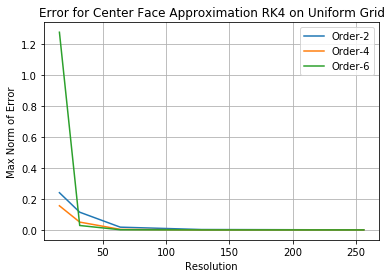

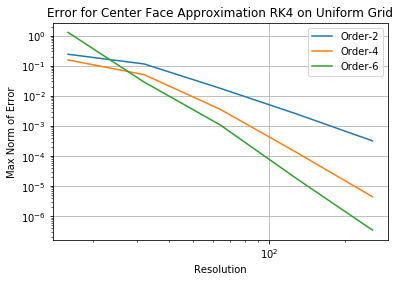

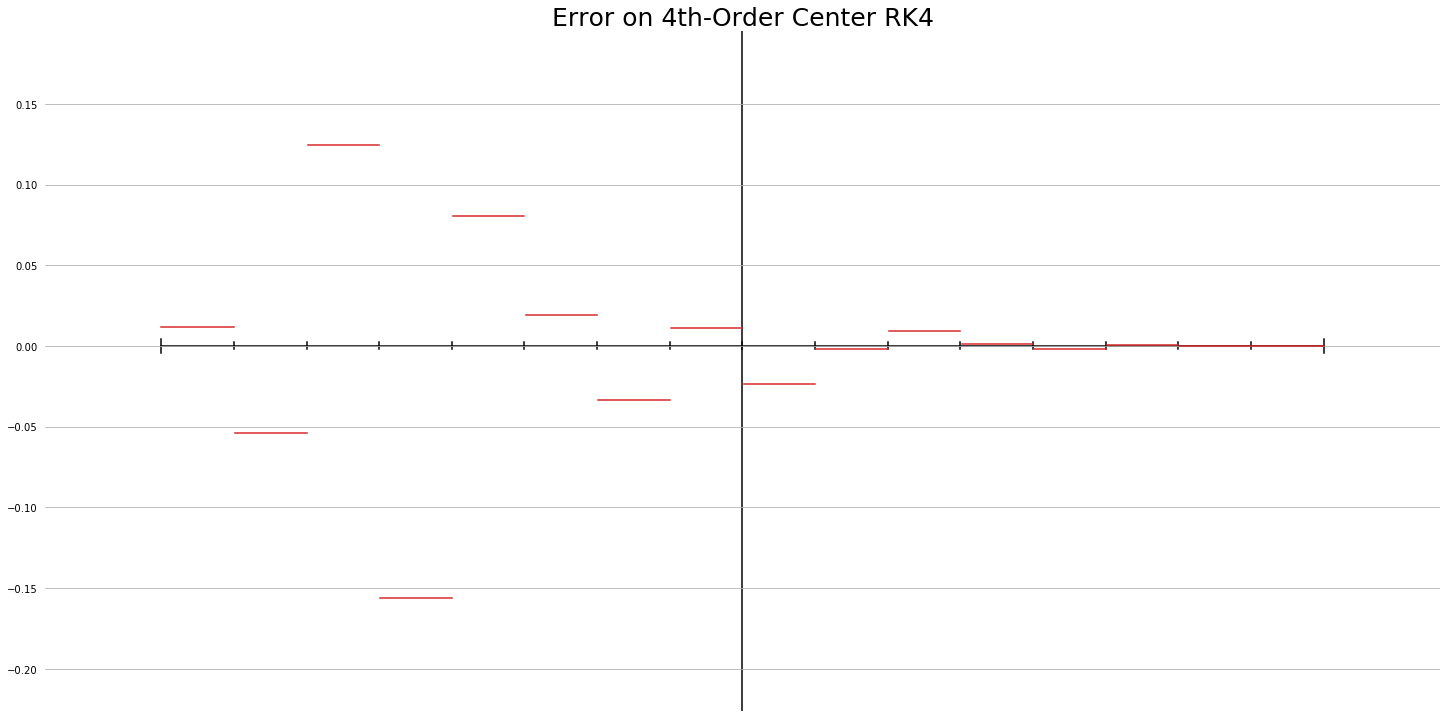

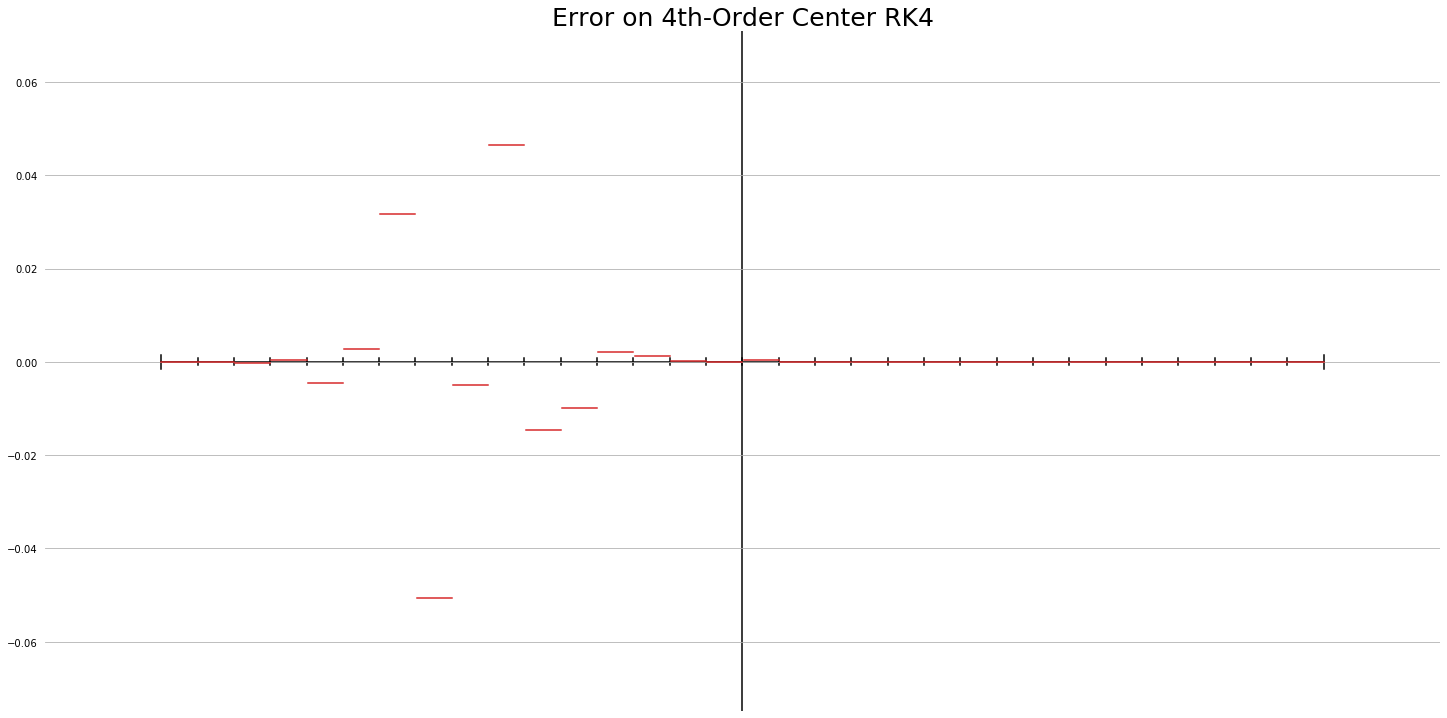

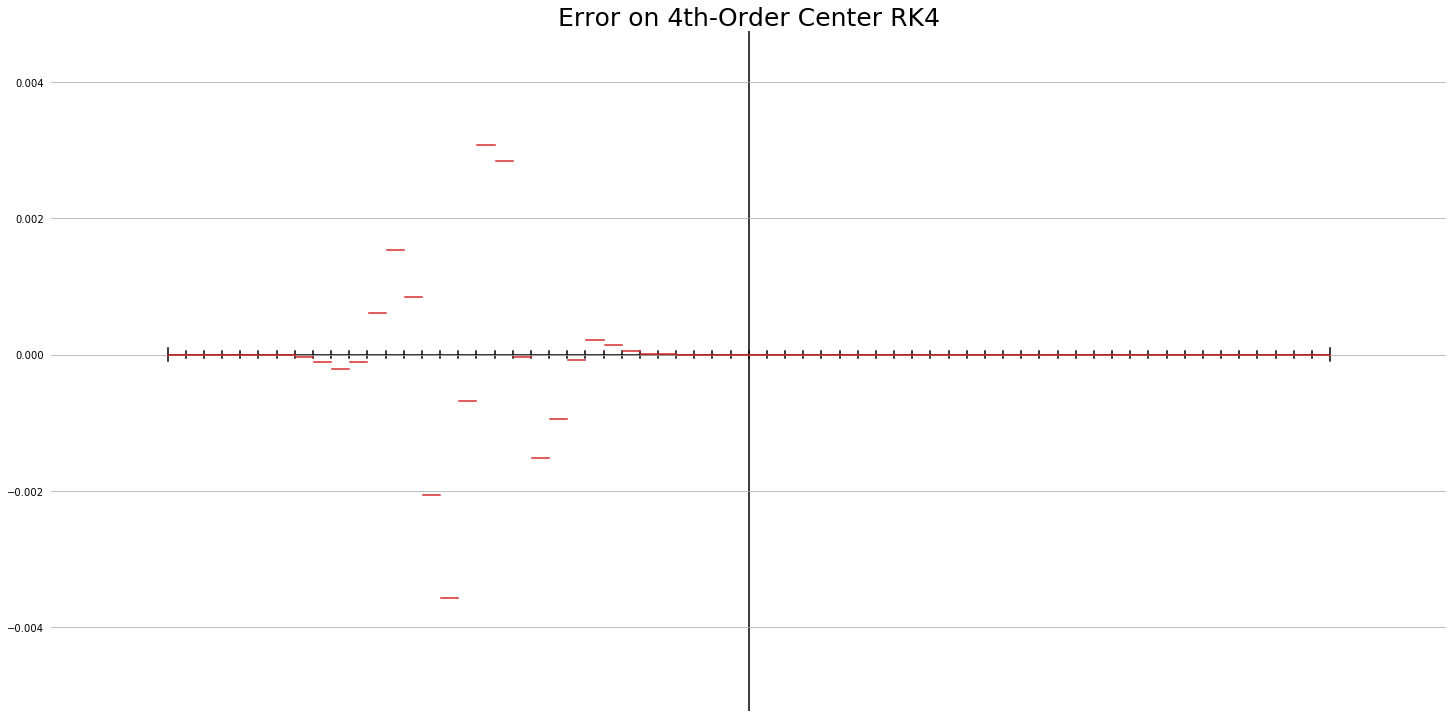

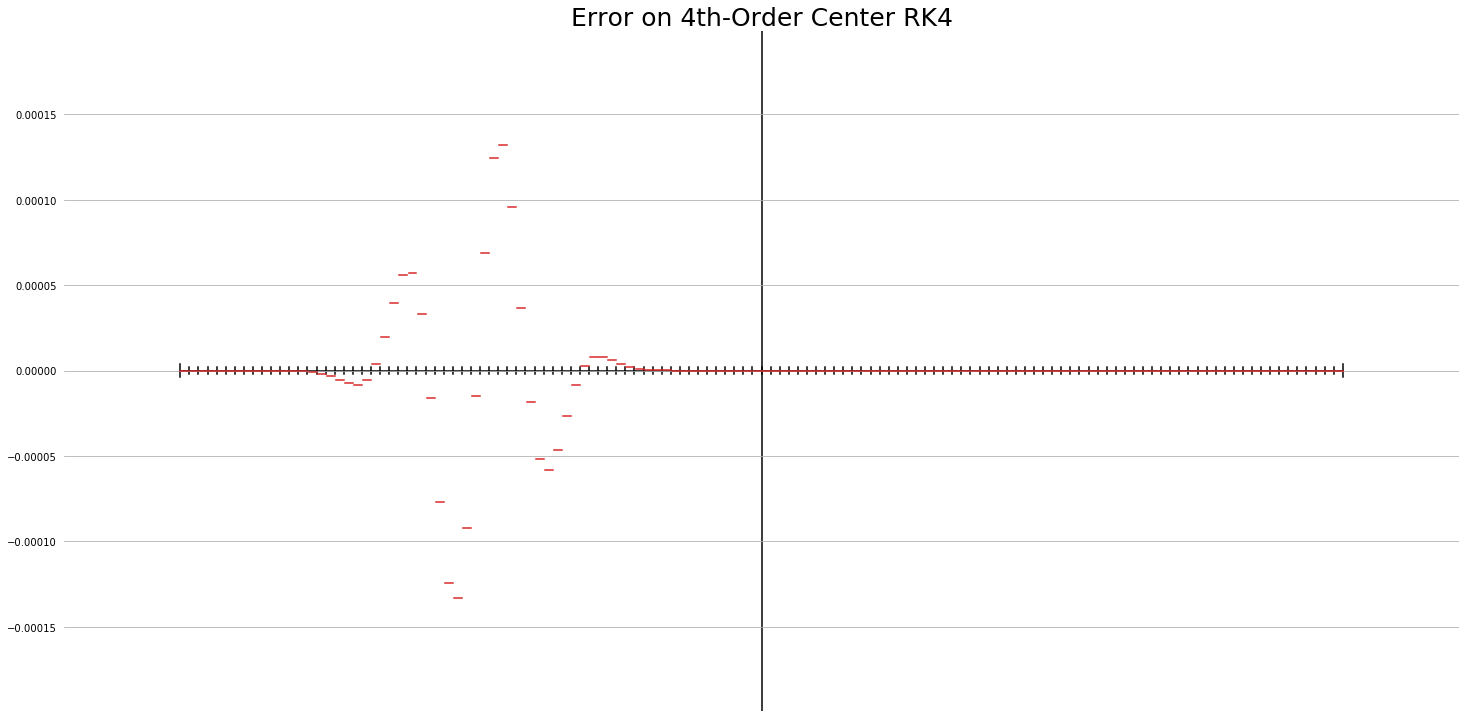

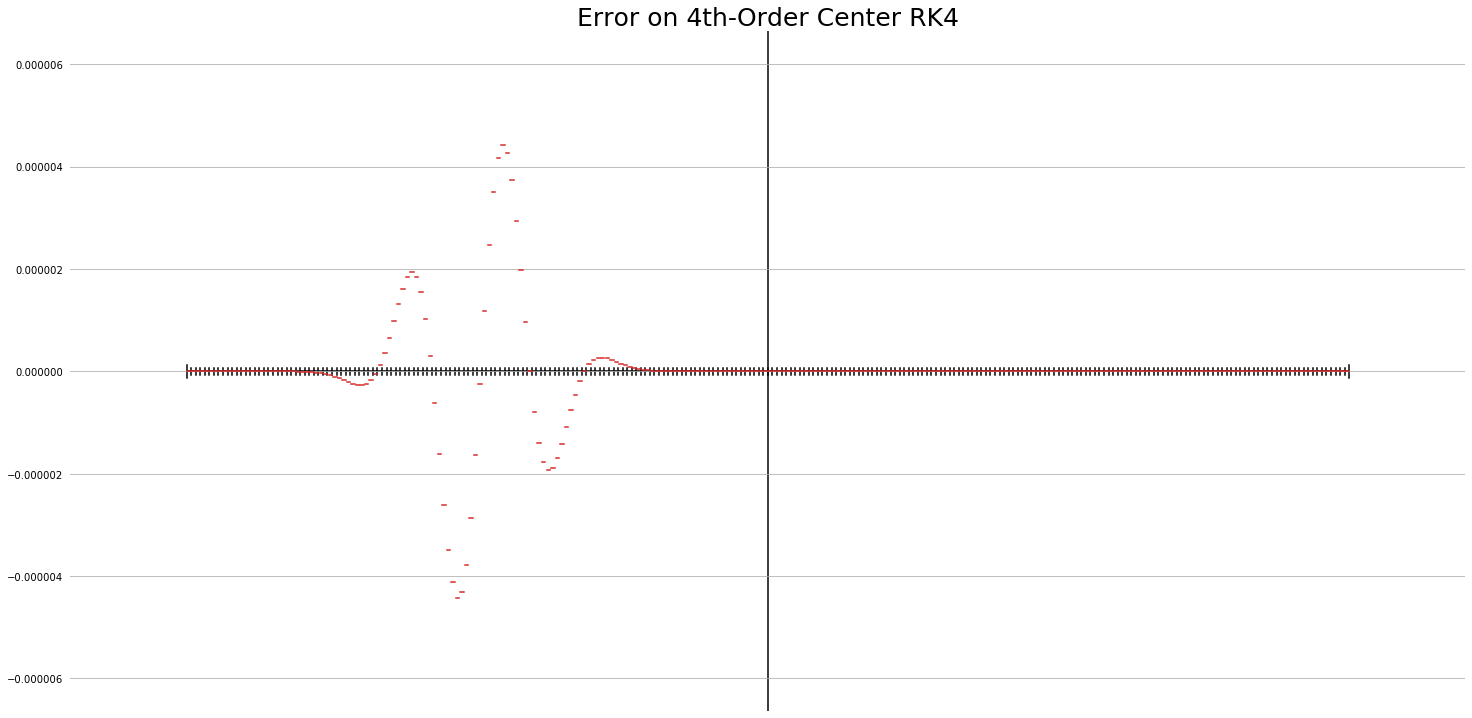

In [7]:
fig1, ax1 = plt.subplots()
plt.title('Error for ' + faceApprox + ' Face Approximation RK' + str(RK) + ' on ' + grid + ' Grid')
plt.ylabel('Max Norm of Error')
plt.xlabel('Resolution')
plt.grid(True)
fig2, ax2 = plt.subplots()
plt.title('Error for ' + faceApprox + ' Face Approximation RK' + str(RK) + ' on ' + grid + ' Grid')
plt.ylabel('Max Norm of Error')
plt.xlabel('Resolution')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')
for o in range(orders):
    order = 2*o + 1
    if ((deriv == 'CD') or (deriv == 'C')):
        order = order + 1
    print('Order:', order)
    print('')
    nhVec, errorTot = WaveEqConvergenceTest(omega0, physics, CFL, RK, order, diff, func, args, dataPts, AMR)
    ax1.plot(nhVec, errorTot, label = 'Order-' + str(order))
    ax2.plot(nhVec, errorTot, label = 'Order-' + str(order))
# ax2.yscale('log')
ax1.legend()
ax2.legend()
fig1.savefig(saveStringLin + '.png', bbox_inches = 'tight', dpi = 300, transparent = False)
fig2.savefig(saveStringLog + '.png', bbox_inches = 'tight', dpi = 300, transparent = False)
plt.show()
plt.show()

# fig, ax = plt.subplots()
# plt.plot(nhVec, errorTot)
# plt.title('Error for Order-' + str(order) + ' ' + faceApprox + ' Face Approximation RK' + str(RK) + ' on ' + grid + ' Grid')
# plt.ylabel('Max Norm of Error')
# plt.xlabel('Resolution')
# plt.grid(True)
# plt.yscale('log')
# plt.savefig(saveStringLog + '.png', bbox_inches = 'tight', dpi = 300, transparent = True)
# plt.show()


In [8]:
# def ConvergTest1(omega, deriv, order):
#     # Write in error trap for wavenumber and nh_max.
#     nh_max = omega.nh_max
#     iters = int(np.log(nh_max) / np.log(2))
#     wave = WT.MakeWaves(omega)
#     testWave = 2 * np.pi * wave[:, 2]
#     waves = wave[:, 1]
#     DerivOp = 2 * OT.SpaceDeriv(omega, order, deriv)
#     CoarseOp = GTT.MakeFullWeight(nh_max)
#     exactDerivOp = TT.ExactSpatOp(omega) # , 0, waves, -1, order)
#     exactDeriv = waves @ exactDerivOp
#     nhs = 2 ** (np.arange(iters) + 1)
#     print(iters)
#     NormVec = []#[[] for i in range()]
#     for i in range(iters):
#         print(i)
#         nh = int(nh_max / (2 ** i))
#         DerivOp = 0.5 * DerivOp[:nh, :nh]
#         DerivOp[0, nh - 1] = DerivOp[1, 0]
#         DerivOp[nh - 1, 0] = DerivOp[0, 1]
#         if (i > 0):
#             CoarseOp = CoarseOp[:nh, :int(2 * nh)]
#             waves = CoarseOp @ waves
#             testWave = CoarseOp @ testWave
#             exactDeriv = CoarseOp @ exactDeriv
#         testDeriv = DerivOp @ waves#[:, :nh]
#         errorVec = abs(testDeriv - exactDeriv)#[:, :nh])
#         NormVec.append(TT.VectorNorm(errorVec))
#         print('test and exact:')
#         print(testDeriv)
#         print(exactDeriv)
#         print(testWave)
#         print(errorVec)
#         print(errorVec ** 2)
#         print(sum(errorVec ** 2))
#         print(np.sqrt(sum(errorVec ** 2)))
#         print('')
#         print(NormVec[i])
#     NormVec = np.asarray(NormVec)[::-1].transpose()
#     print('NormVec is')
#     print(NormVec)
#     return nhs, NormVec

In [9]:
# def ConvergTest(omega, deriv, order):
#     # Write in error trap for wavenumber and nh_max.
#     nh_max = omega.nh_max
#     iters = int(np.log(nh_max) / np.log(2))
#     waves = WT.MakeWaves(omega)
# #     testWave = 2 * np.pi * wave[:, 2]
# #     waves = wave[:, 1]
#     DerivOp = 2 * OT.SpaceDeriv(omega, order, deriv)
#     CoarseOp = GTT.MakeFullWeight(nh_max)
#     exactDerivOp = TT.ExactSpatOp(omega) #, 0, waves, -1, order)
#     exactDeriv = waves @ exactDerivOp
#     nhs = 2 ** (np.arange(iters) + 1)
#     print(iters)
#     NormVecs = np.zeros((iters, nh_max), float)#[[] for i in range()]
#     mask = np.zeros(nh_max, int)
#     masks = []
#     for i in range(iters):
#         print(i)
#         nh = int(nh_max / (2 ** i))
        
#         mask[:nh] = 1
#         masks.append(list(mask))
#         # mask = list(mask)
#         print('mask:')
#         print(mask)
#         print(masks)
#         DerivOp = 0.5 * DerivOp[:nh, :nh]
#         DerivOp[0, nh - 1] = DerivOp[1, 0]
#         DerivOp[nh - 1, 0] = DerivOp[0, 1]
#         if (i > 0):
#             CoarseOp = CoarseOp[:nh, :int(2 * nh)]
#             waves = CoarseOp @ waves
# #             testWave = CoarseOp @ testWave
#             exactDeriv = CoarseOp @ exactDeriv
#         testDeriv = DerivOp @ waves#[:, :nh]
#         errorVec = abs(testDeriv - exactDeriv)#[:, :nh])
#         NormVec = TT.VectorNorm(errorVec)
        
#         #NormVec = ma.masked_array(NormVec, mask = mask)
        
#         NormVecs[i, :] = NormVec
#         print('Before Mask:')
#         print(NormVecs[i, :])
        
#         print('After Mask:')
#         print(NormVecs[i, :])
#         #print(NormVecs[::-1])
#         print('test and exact:')
#         print(testDeriv)
#         print(exactDeriv)
# #         print(testWave)
#         print(errorVec)
#         print(errorVec ** 2)
#         print(sum(errorVec ** 2, axis = 0))
#         print(np.sqrt(sum(errorVec ** 2, axis = 0)))
#         print('')
#         print(NormVecs[i])
#     masks = [item for sublist in masks for item in sublist]
#     print(masks)
#     print(NormVecs)
#     NormVecs = np.asarray(NormVecs)[::-1]#.transpose()
#     ma.masked_array(NormVecs, mask = list(masks))
#     print('NormVecs is')
#     print(NormVecs)
#     return nhs, NormVecs

In [10]:
# nhs1, NormVec1 = ConvergTest1(omega, deriv, order)
# print(nhs1)


In [11]:
# nhs, NormVec = ConvergTest(omega, deriv, order)
# print(nhs)


In [12]:
# plt.figure()
# plt.plot(nhs1, NormVec1)
# print(NormVec1)
# print('')
# plt.show()

In [13]:
# plt.figure()
# plt.plot(nhs, NormVec[:, 1])
# print(NormVec[:, 1])
# print('')
# plt.yscale('log')
# plt.show()

In [14]:
# print('32:', [0.16092122, 0.45034975, 1.22071342, 2.90704182, 0.90031632])
# print('512:', [2.52326242e-03, 7.13656831e-03, 2.01819198e-02, 5.70452747e-02, 1.60921219e-01, 4.50349746e-01, 1.22071342e+00, 2.90704182e+00, 9.00316316e-01])

In [15]:
# A = np.arange(16).reshape(4, 4)
# print(A)
# print(A ** 2)
# print('')
# print(sum(A, axis = 0))
# out = TT.VectorNorm(A)
# print(out)
# print(A[:, :2])
# A = ma.masked_array(A, mask=[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])
# print(A)
# print(type([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]))
# C = np.ones(6, float)
# print(type(C))
# C = list(C)
# print(type(C))